In [1]:
# === 📦 Imports ===
import pandas as pd
import torch
import numpy as np
from neuralforecast.models import NHITS
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE, MSE, RMSE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# === ✅ Step 1: Check GPU availability ===
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060 Ti


In [3]:
# === 📥 Step 2: Load and Prepare Data ===
df = pd.read_csv("C:/Users/mloai/Event-Aware Sales Forecasting with Time Series Models/sales_with_features1.csv")

In [4]:
df[['LOG_SALES']]
df['SALES_AMOUNT'] = np.expm1(df['LOG_SALES'])

In [5]:

cols_to_drop = [
    'Is_Vacation' ,'Is_Pre_Ramadan', 'Is_Ramadan'  ,'Is_MegaSale', 'Is_regular','Is_Summer',
    'Is_Winter', 'Is_Spring','Is_Eid_Fitr','Is_Eid_Adha', 'Is_Month_Start', 'Is_Month_End',
    'is_Summer_Calendar', 'is_Winter_Calendar', 'is_Spring_Calendar', 'is_Fall_Calendar','LOG_SALES'
]

df = df.drop(columns=cols_to_drop)



In [6]:
# Convert columns to a list
columns_list = df.columns.tolist()

print(columns_list)

['CAL_DATE', 'HIJRI_DATE', 'Main Event', 'Category_Channel', 'Hijri_Month', 'Day', 'Month', 'Year', 'Quarter', 'DayOfYear', 'Week', 'Weekday', 'Is_Weekend', 'Is_Week_Start', 'Days_Since_Start', 'event_category', 'event_Back_To_School', 'event_Calendar_Promo', 'event_Campaign_Driven', 'event_Eid', 'event_Mega_Sale', 'event_National_Event', 'event_Other_Event', 'event_Ramadan_Campaign', 'event_Regular', 'event_Seasonal_Event', 'sales_lag_1', 'sales_lag_14', 'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_std_7', 'sales_roll_std_14', 'SALES_AMOUNT']


In [7]:
# Rename to match NeuralForecast expectations
df_nf = df.rename(columns={
    'CAL_DATE': 'ds',
    'SALES_AMOUNT': 'y'
})
df_nf['ds'] = pd.to_datetime(df_nf['ds'])
df_nf['unique_id'] = df['Category_Channel']
df_nf = df_nf[['unique_id', 'ds', 'y']]

print(f"Original dataset shape: {df_nf.shape}")
print(f"Sales range: {df_nf['y'].min():.2f} to {df_nf['y'].max():.2f}")

Original dataset shape: (40684, 3)
Sales range: 1000.02 to 43419254.06


In [8]:
df_nf.head()

,unique_id,ds,y
0,100_Brick and Mortar,2024-02-24,1022.70
1,100_Brick and Mortar,2024-09-20,1135.13
2,100_Brick and Mortar,2024-09-23,1231.29
3,101_Brick and Mortar,2022-05-28,5936.51
4,101_Brick and Mortar,2022-05-30,4222.63


In [9]:
# === 🔧 Step 3: Improved Data Preprocessing ===
# Handle near-zero values (replace with small positive value)
df_nf['y'] = df_nf['y'].clip(lower=0.01)  # Ensure no zeros/negatives

# Log transform to handle extreme scales
df_nf['y_log'] = np.log1p(df_nf['y'])  # log(1+y) to handle zeros
df_nf['y_original'] = df_nf['y']  # Keep original for later
df_nf['y'] = df_nf['y_log']  # Use log-transformed values

print(f"After log transform - range: {df_nf['y'].min():.2f} to {df_nf['y'].max():.2f}")


After log transform - range: 6.91 to 17.59


In [10]:
# === ✂️ Step 4: Split Train/Test ===
train_cutoff = pd.to_datetime('2025-01-01')
forecast_end = pd.to_datetime('2025-05-25')

df_train = df_nf[df_nf['ds'] < train_cutoff].copy()
df_test = df_nf[(df_nf['ds'] >= train_cutoff) & (df_nf['ds'] <= forecast_end)].copy()

horizon = (forecast_end - train_cutoff).days + 1
print(f"Horizon: {horizon} days")

Horizon: 145 days


In [11]:
# === 🎯 Step 5: Multiple Model Configurations ===
models = [
    # Model 1: Conservative (your current working model)
    NHITS(
        h=horizon,
        input_size=60,
        loss=MAE(),
        max_steps=2000,
        learning_rate=1e-3,
        scaler_type='standard',
        random_seed=42,
        alias='NHITS_Conservative'
    ),
    
    # Model 2: Improved (recommended settings)
    NHITS(
        h=horizon,
        input_size=90,
        loss=MAE(),
        max_steps=3000,
        learning_rate=5e-4,
        scaler_type='standard',
        random_seed=42,
        alias='NHITS_Improved'
    ),
    
    # Model 3: Robust (for high-variance data)
    NHITS(
        h=horizon,
        input_size=120,
        loss=RMSE(),
        max_steps=2500,
        learning_rate=1e-4,
        scaler_type='robust',
        random_seed=42,
        alias='NHITS_Robust'
    )
]


Seed set to 42
Seed set to 42
Seed set to 42


In [12]:
# === 🤖 Step 6: Train Multiple Models ===
results = {}
val_size = max(150, horizon)

for i, model in enumerate(models):
    print(f"\n🔄 Training Model {i+1}: {model.alias}")
    print("=" * 50)
    
    try:
        nf = NeuralForecast(models=[model], freq='D')
        nf.fit(df=df_train, val_size=val_size)
        
        # Predict
        df_forecast = nf.predict()
        
        # Transform predictions back to original scale
        df_forecast[model.alias] = np.expm1(df_forecast[model.alias])  # Reverse log transform
        df_forecast[model.alias] = df_forecast[model.alias].clip(lower=0)  # Ensure non-negative
        
        # Store results
        results[model.alias] = {
            'model': nf,
            'predictions': df_forecast
        }
        
        print(f"✅ {model.alias} trained successfully!")
        
    except Exception as e:
        print(f"❌ {model.alias} failed: {e}")
        continue


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



🔄 Training Model 1: NHITS_Conservative



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.596    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.904    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


✅ NHITS_Conservative trained successfully!

🔄 Training Model 2: NHITS_Improved


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=3000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.211    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


✅ NHITS_Improved trained successfully!

🔄 Training Model 3: NHITS_Robust


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ NHITS_Robust trained successfully!


In [13]:
# === 📊 Step 7: Evaluate All Models ===
print(f"\n📊 Model Comparison:")
print("=" * 60)

# Get original scale test data
df_test_orig = df_test.copy()
df_test_orig['y'] = df_test_orig['y_original']

model_performance = {}

for model_name, result in results.items():
    df_forecast = result['predictions']
    
    # Merge with test data
    df_eval = df_forecast.merge(df_test_orig, on=['unique_id', 'ds'], how='inner')
    
    if len(df_eval) > 0:
        # Calculate metrics on original scale
        actual = df_eval['y'].values
        predicted = df_eval[model_name].values
        
        # Remove any remaining invalid values
        mask = ~(np.isnan(actual) | np.isnan(predicted) | np.isinf(actual) | np.isinf(predicted))
        actual = actual[mask]
        predicted = predicted[mask]
        
        if len(actual) > 0:
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            
            # Better SMAPE calculation
            smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
            
            # MAPE for non-zero values only
            non_zero_mask = actual > 1
            if np.sum(non_zero_mask) > 0:
                mape = 100 * np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask]))
            else:
                mape = np.inf
            
            correlation = np.corrcoef(actual, predicted)[0, 1] if len(actual) > 1 else 0
            
            model_performance[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'SMAPE': smape,
                'MAPE': mape,
                'Correlation': correlation,
                'Predictions': len(actual)
            }
            
            print(f"\n{model_name}:")
            print(f"  MAE: {mae:,.2f}")
            print(f"  RMSE: {rmse:,.2f}")
            print(f"  SMAPE: {smape:.2f}%")
            print(f"  MAPE: {mape:.2f}%" if mape != np.inf else "  MAPE: Undefined")
            print(f"  Correlation: {correlation:.4f}")



📊 Model Comparison:

NHITS_Conservative:
  MAE: 242,683.30
  RMSE: 849,828.41
  SMAPE: 50.99%
  MAPE: 84.57%
  Correlation: 0.7862

NHITS_Improved:
  MAE: 266,394.97
  RMSE: 987,109.21
  SMAPE: 53.16%
  MAPE: 95.38%
  Correlation: 0.6976

NHITS_Robust:
  MAE: 225,945.72
  RMSE: 900,814.45
  SMAPE: 50.28%
  MAPE: 85.77%
  Correlation: 0.7638



🏆 Best Model: NHITS_Robust (SMAPE: 50.28%)

📈 Plotting results for NHITS_Robust...


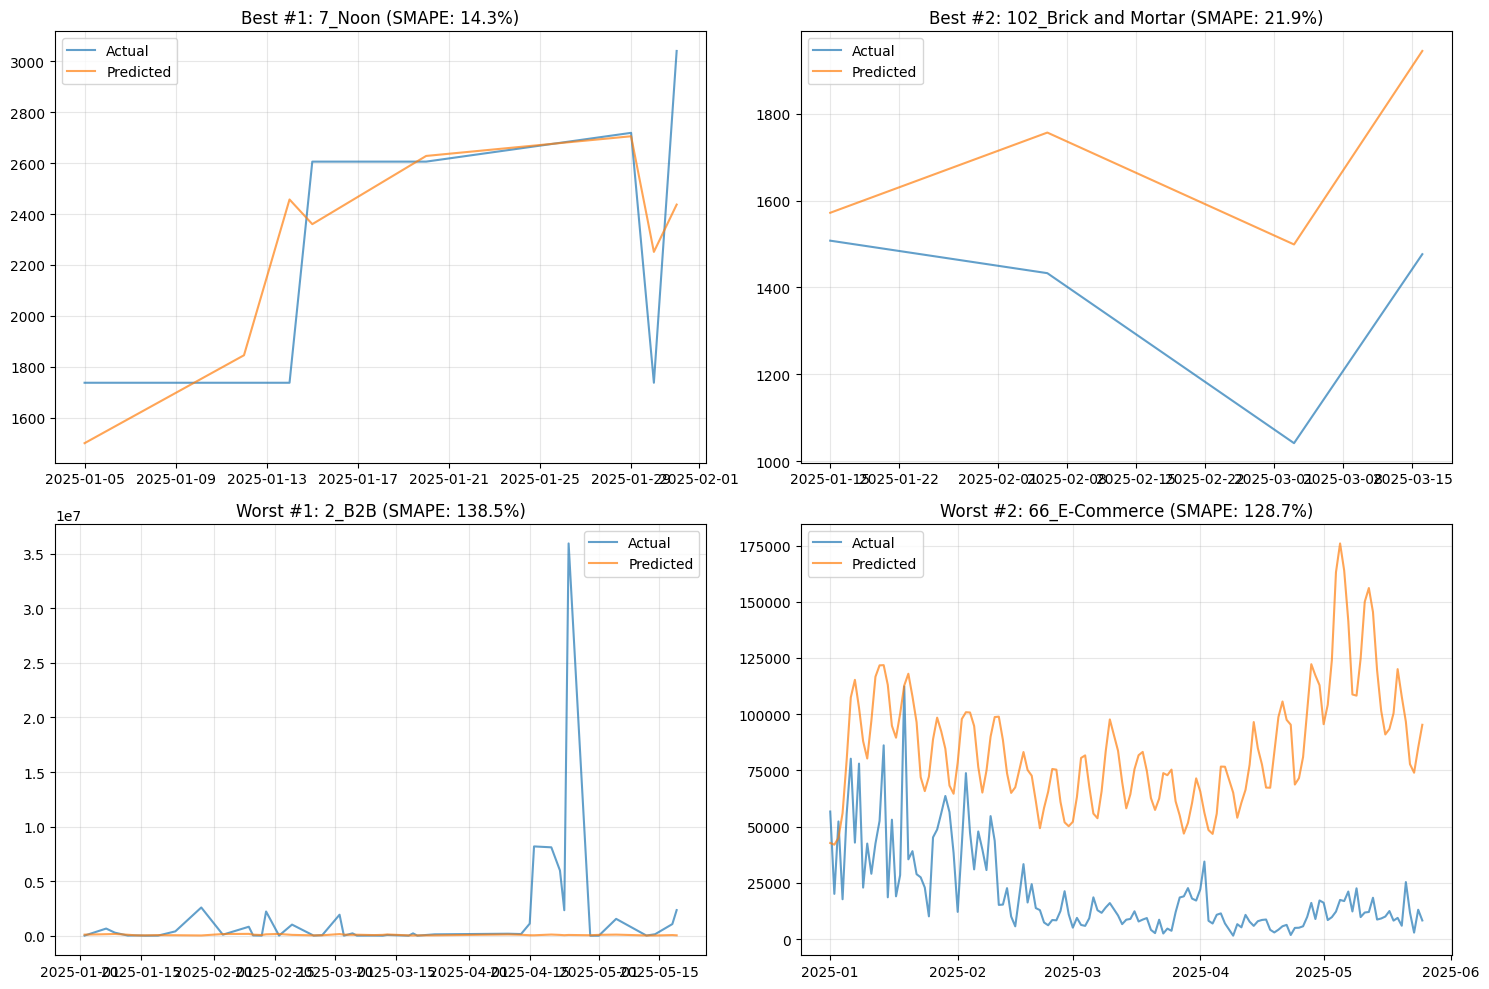


✅ Results saved! Best model achieved 50.28% SMAPE


In [14]:
# === 🏆 Step 8: Select Best Model ===
if model_performance:
    best_model = min(model_performance.items(), key=lambda x: x[1]['SMAPE'])
    print(f"\n🏆 Best Model: {best_model[0]} (SMAPE: {best_model[1]['SMAPE']:.2f}%)")
    
    # Use best model for detailed analysis
    best_predictions = results[best_model[0]]['predictions']
    df_eval_best = best_predictions.merge(df_test_orig, on=['unique_id', 'ds'], how='inner')
    
    # === 📈 Step 9: Visualizations ===
    def plot_best_worst_series(df_eval, model_name):
        """Plot best and worst performing series"""
        
        # Calculate SMAPE per series
        series_smape = df_eval.groupby('unique_id').apply(
            lambda x: 100 * np.mean(2 * np.abs(x[model_name] - x['y']) / (np.abs(x['y']) + np.abs(x[model_name])))
        ).reset_index()
        series_smape.columns = ['unique_id', 'smape']
        
        # Get best and worst
        best_series = series_smape.nsmallest(2, 'smape')['unique_id'].tolist()
        worst_series = series_smape.nlargest(2, 'smape')['unique_id'].tolist()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        all_series = best_series + worst_series
        titles = ['Best #1', 'Best #2', 'Worst #1', 'Worst #2']
        
        for i, (uid, title) in enumerate(zip(all_series, titles)):
            series_data = df_eval[df_eval['unique_id'] == uid].sort_values('ds')
            
            axes[i].plot(series_data['ds'], series_data['y'], label='Actual', alpha=0.7)
            axes[i].plot(series_data['ds'], series_data[model_name], label='Predicted', alpha=0.7)
            axes[i].set_title(f'{title}: {uid}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Add SMAPE to title
            smape_val = series_smape[series_smape['unique_id'] == uid]['smape'].iloc[0]
            axes[i].set_title(f'{title}: {uid} (SMAPE: {smape_val:.1f}%)')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n📈 Plotting results for {best_model[0]}...")
    plot_best_worst_series(df_eval_best, best_model[0])
    
    # === 💾 Step 10: Save Results ===
    df_eval_best.to_csv('nhits_improved_results.csv', index=False)
    
    # Save model performance comparison
    performance_df = pd.DataFrame(model_performance).T
    performance_df.to_csv('model_comparison.csv')
    
    print(f"\n✅ Results saved! Best model achieved {best_model[1]['SMAPE']:.2f}% SMAPE")
    
else:
    print("❌ No models trained successfully")


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_series(df_eval, model_name, max_plots=None):
    """Plot all series (Actual vs Predicted). Optionally limit to `max_plots` for readability."""
    
    unique_ids = df_eval['unique_id'].unique()
    if max_plots:
        unique_ids = unique_ids[:max_plots]

    n_series = len(unique_ids)
    ncols = 2
    nrows = int(np.ceil(n_series / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
    axes = axes.flatten()

    for i, uid in enumerate(unique_ids):
        ax = axes[i]
        series_data = df_eval[df_eval['unique_id'] == uid].sort_values('ds')

        ax.plot(series_data['ds'], series_data['y'], label='Actual', alpha=0.7)
        ax.plot(series_data['ds'], series_data[model_name], label='Predicted', alpha=0.7)
        ax.set_title(f'Series: {uid}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


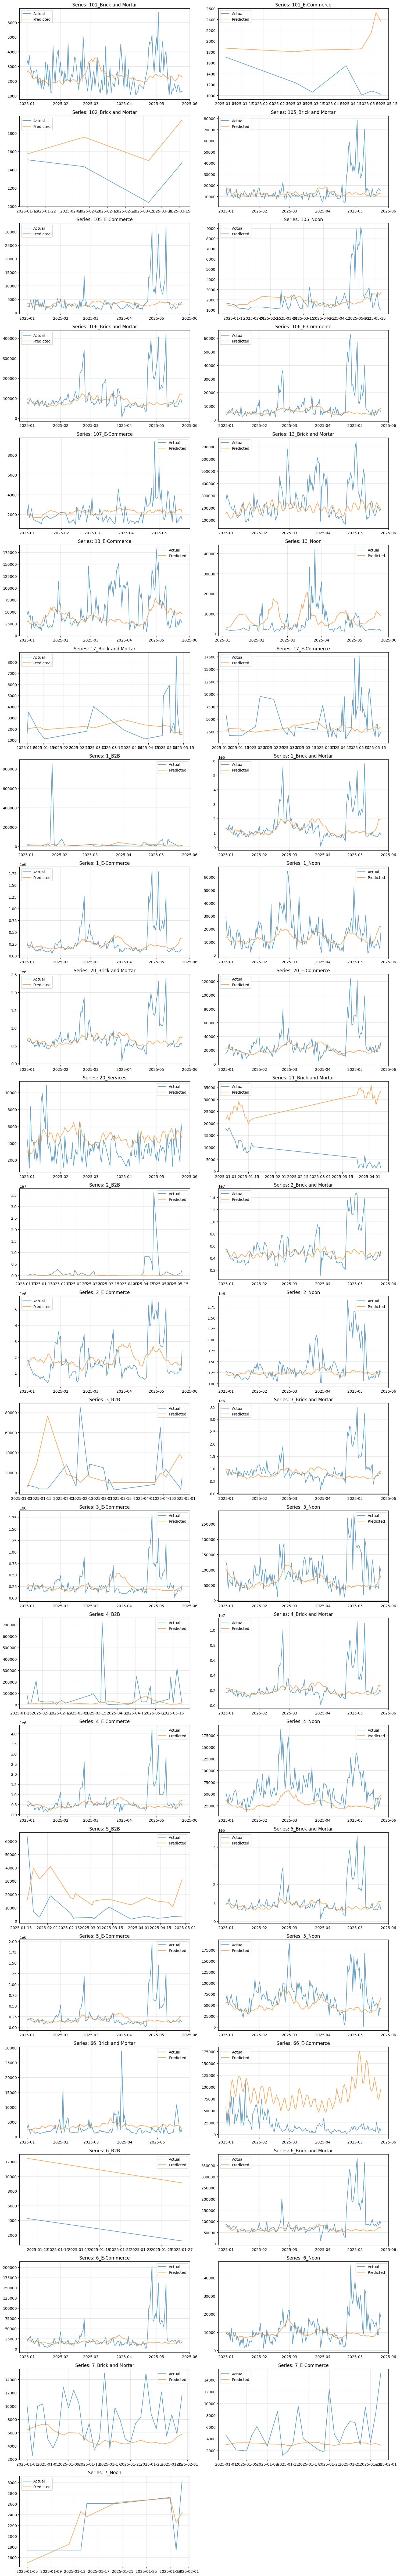

In [16]:
# To plot all series:
plot_all_series(df_eval_best, best_model[0])


In [17]:
# === 💡 Final Recommendations ===
print(f"\n💡 Final Recommendations:")
print("=" * 50)
print("✅ Log transformation helped handle extreme scales")
print("✅ Multiple model comparison shows robustness")
print("🔧 For further improvement, consider:")
print("   • Adding external features (holidays, promotions)")
print("   • Ensemble methods (combine multiple models)")
print("   • Different architectures (TiDE, PatchTST)")
print("   • Series-specific models for different channels")


💡 Final Recommendations:
✅ Log transformation helped handle extreme scales
✅ Multiple model comparison shows robustness
🔧 For further improvement, consider:
   • Adding external features (holidays, promotions)
   • Ensemble methods (combine multiple models)
   • Different architectures (TiDE, PatchTST)
   • Series-specific models for different channels


In [18]:
df_eval_best.to_csv('nhits_improved_results.csv', index=False)


In [19]:
df.head()

,CAL_DATE,HIJRI_DATE,Main Event,Category_Channel,Hijri_Month,Day,Month,Year,Quarter,DayOfYear,...,event_Ramadan_Campaign,event_Regular,event_Seasonal_Event,sales_lag_1,sales_lag_14,sales_roll_mean_7,sales_roll_mean_14,sales_roll_std_7,sales_roll_std_14,SALES_AMOUNT
0,2024-02-24,1445-08-14,Regular,100_Brick and Mortar,8,24,2,2024,1,55,...,0,1,0,7.159144,7.189703,7.107233,7.216995,0.178643,0.249347,1022.70
1,2024-09-20,1446-03-17,Nd,100_Brick and Mortar,3,20,9,2024,3,264,...,0,0,0,6.931179,7.662242,7.098866,7.172220,0.180728,0.217491,1135.13
2,2024-09-23,1446-03-20,Nd,100_Brick and Mortar,3,23,9,2024,3,267,...,0,0,0,7.035383,7.061034,7.120139,7.176191,0.171233,0.215806,1231.29
3,2022-05-28,1443-10-27,Mega Sale,101_Brick and Mortar,10,28,5,2022,2,148,...,0,0,0,7.188111,7.298709,7.532717,7.670154,0.594412,0.518325,5936.51
4,2022-05-30,1443-10-29,Mega Sale,101_Brick and Mortar,10,30,5,2022,2,150,...,0,0,0,8.689045,8.315163,7.715504,7.672532,0.624021,0.521577,4222.63


In [20]:
df_XGB = pd.read_csv("C:/Users/mloai/Event-Aware Sales Forecasting with Time Series Models/sales_predictions_XGB.csv")

In [21]:
# List of columns to drop
cols_to_drop = ['y', 'y_log']  # replace with actual column names

# Drop the columns
df_eval_best = df_eval_best.drop(columns=cols_to_drop)

# Ensure date column is datetime format
df_eval_best['ds'] = pd.to_datetime(df_eval_best['ds'])
df_XGB['ds'] = pd.to_datetime(df_XGB['ds'])

# Rename prediction columns to distinguish them
df_eval_best.rename(columns={'PREDICTED_SALES': 'NHITS_PREDICTION'}, inplace=True)
df_XGB.rename(columns={'PREDICTED_SALES': 'XGB_PREDICTION'}, inplace=True)

# Merge on 'unique_id' and 'ds'
merged_df = pd.merge(df_eval_best, df_XGB, on=['unique_id', 'ds'], how='inner')

# ✅ Optional: Preview result
print(merged_df.head())

# ✅ Optional: Save to CSV
merged_df.to_csv("merged_forecasts.csv", index=False)


              unique_id         ds  NHITS_Robust  y_original  HIJRI_DATE  \
0  101_Brick and Mortar 2025-01-01   2599.102295     3388.52  1446-07-01   
1  101_Brick and Mortar 2025-01-02   2698.989990     3112.15  1446-07-02   
2  101_Brick and Mortar 2025-01-03   2591.447754     3728.18  1446-07-03   
3  101_Brick and Mortar 2025-01-04   2514.318848     2816.12  1446-07-04   
4  101_Brick and Mortar 2025-01-05   2359.712646     2705.04  1446-07-05   

    Main Event  SALES_AMOUNT  XGB_PREDICTION  
0  End Of Year       3388.52       3014.0813  
1  End Of Year       3112.15       3008.4565  
2  End Of Year       3728.18       3083.9604  
3  End Of Year       2816.12       3183.2842  
4  End Of Year       2705.04       3160.7556  
